<a href="https://colab.research.google.com/github/lkamimura/SimulacionDinamica/blob/main/Clase06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e
#-------#2min la JULIA_VERSION="1.10.2", dar F5--------------------------------------------#
JULIA_VERSION="1.10.2" # any version ≥ 0.7.0 iba 8 en lugar de 10
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#
if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz
  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done
  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia
  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

In [ ]:
versioninfo()

In [ ]:
using Pkg;
Pkg.add("Plots") #5min

In [3]:
using Plots

In [ ]:
Pkg.add("LaTeXStrings")
using LaTeXStrings

In [ ]:
Pkg.add("Symbolics") #3min en Colab, 2min en visualstudio
using Symbolics

#Caso del avión

In [5]:
function modavion(t_etapa, xant, accion)
  a=0.01; b=2; c=100;
  omega=0.2;
  At=1e-3;
  u=accion;
  #%xant=[alfa,fi,fi_p,h]
  alfa=xant[1];
  fi=xant[2];
  fi_p=xant[3];
  h=xant[4];
  x=xant;
  for ii = 1:t_etapa/At
    #%xp=A*x+B*u;
    alfa_p=a*(fi-alfa);
    fi_pp=(-omega^2)*(fi-alfa-b*u);
    h_p=c*alfa;
    xp=[alfa_p,fi_p,fi_pp,h_p];
    x=x+xp*At;
    fi_p=xp[2];
    alfa=x[1];
    fi=x[2];
    fi_p=x[3];
    h=x[4];
  end
  X=x;
end
#=
%Funcion modelo
function [X]=modavion(t_etapa, xant, accion)
%xant=[alfa,fi,fi_p,h]
a=0.01; b=2; c=100;
omega=0.2;
At=1e-3;
u=accion;
%xant=[alfa,fi,fi_p,h]
alfa=xant(1);
fi=xant(2);
fi_p=xant(3);
h=xant(4);
x=xant;
for ii=1:t_etapa/At
  %xp=A*x+B*u;
  alfa_p=a*(fi-alfa);
  fi_pp=(-omega^2)*(fi-alfa-b*u);
  h_p=c*alfa;
  xp=[alfa_p;fi_p;fi_pp;h_p];
  x=x+xp*At;
  fi_p=xp(2);
  alfa=x(1);
  fi=x(2);
  fi_p=x(3);
  h=x(4);
end
X=[x];%
=#

modavion (generic function with 1 method)

In [29]:
X=-[0, 0,0,0];t_etapa=10e-3;
tF=5.;
Ts=t_etapa;
N_val = tF/Ts;
#=%A1=((2*Kp*Ts)+(Ki*(Ts^2))+(2*Kd))/(2*Ts);
%B1=(-2*Kp*Ts+Ki*(Ts^2)-4*Kd)/(2*Ts);
%C1=Kd/Ts;
%e=zeros(round(tF/t_etapa),1); =#
u=0;
x2 = Array{Float64, 1}(undef, trunc(Int, N_val)); #una columna con N_val elementos
x4 = Array{Float64, 1}(undef, trunc(Int, N_val)); #una columna con N_val elementos
acc= Array{Float64, 1}(undef, trunc(Int, N_val)); #una columna con N_val elementos
ii=0;
for t=0:t_etapa:tF-t_etapa
  ii=ii+1;
  x2[ii]=X[2];#%Ángulo fi
  x4[ii]=X[4];#%tensión en el capacitor
  X=modavion(t_etapa, X, u);
  acc[ii]=u;
  u=1;
end
t=0:t_etapa:tF-t_etapa;

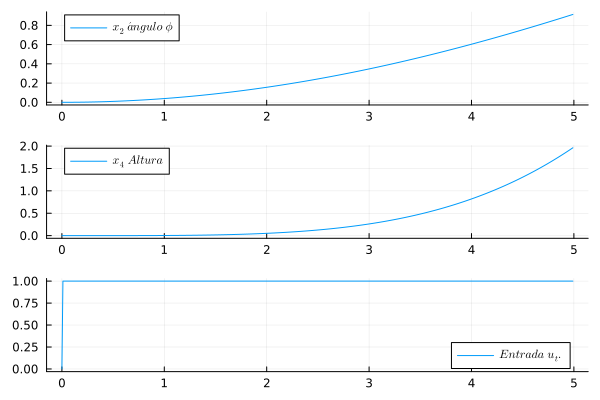

In [30]:
P1=plot(t, x2, label=L"x_2 \ \'angulo \  \phi", lw=1)
P2=plot(t, x4, label=L"x_4 \ Altura", lw=1)
P3=plot(t, acc, label=L"Entrada \ u_t.", lw=1)
plot(P1, P2, P3, layout=(3,1) )
#plot(P1, P2, P3, layout=grid(3, 1, heights=[0.8 ,0.2, 1.1]))

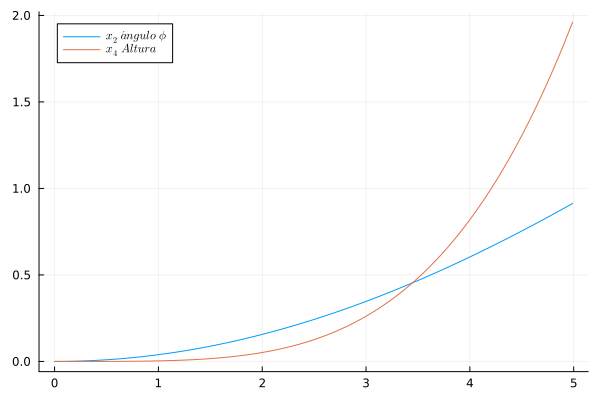

In [36]:
plot(t, x2, label=L"x_2 \ \'angulo \  \phi")
plot!(t, x4, label=L"x_4 \ Altura")

#Punto2

In [37]:
function modavion2(t_etapa, xant, accion)
  a=0.01; b=2; c=50;
  omega=0.2;
  At=1e-3;
  u=accion;
  #%xant=[alfa,fi,fi_p,h]
  alfa=xant[1];
  fi=xant[2];
  fi_p=xant[3];
  h=xant[4];
  x=xant;
  for ii = 1:t_etapa/At
    #%xp=A*x+B*u;
    alfa_p=a*(fi-alfa);
    fi_pp=(-omega^2)*(fi-alfa-b*u);
    h_p=c*alfa;
    xp=[alfa_p,fi_p,fi_pp,h_p];
    x=x+xp*At;
    fi_p=xp[2];
    alfa=x[1];
    fi=x[2];
    fi_p=x[3];
    h=x[4];
  end
  X=x;
end
#=
%Funcion modelo
function [X]=modavion(t_etapa, xant, accion)
%xant=[alfa,fi,fi_p,h]
a=0.01; b=2; c=100;
omega=0.2;
At=1e-3;
u=accion;
%xant=[alfa,fi,fi_p,h]
alfa=xant(1);
fi=xant(2);
fi_p=xant(3);
h=xant(4);
x=xant;
for ii=1:t_etapa/At
  %xp=A*x+B*u;
  alfa_p=a*(fi-alfa);
  fi_pp=(-omega^2)*(fi-alfa-b*u);
  h_p=c*alfa;
  xp=[alfa_p;fi_p;fi_pp;h_p];
  x=x+xp*At;
  fi_p=xp(2);
  alfa=x(1);
  fi=x(2);
  fi_p=x(3);
  h=x(4);
end
X=[x];%
=#

modavion2 (generic function with 1 method)

In [38]:
X=-[0, 0,0,0];t_etapa=10e-3;
tF=20.;
Ts=t_etapa;
N_val = tF/Ts;
#=%A1=((2*Kp*Ts)+(Ki*(Ts^2))+(2*Kd))/(2*Ts);
%B1=(-2*Kp*Ts+Ki*(Ts^2)-4*Kd)/(2*Ts);
%C1=Kd/Ts;
%e=zeros(round(tF/t_etapa),1); =#
u=0;
x2 = Array{Float64, 1}(undef, trunc(Int, N_val)); #una columna con N_val elementos
x4 = Array{Float64, 1}(undef, trunc(Int, N_val)); #una columna con N_val elementos
acc= Array{Float64, 1}(undef, trunc(Int, N_val)); #una columna con N_val elementos
ii=0;
for t=0:t_etapa:tF-t_etapa
  ii=ii+1;
  x2[ii]=X[2];#%Ángulo fi
  x4[ii]=X[4];#%tensión en el capacitor
  X=modavion2(t_etapa, X, u);
  acc[ii]=u;
  u=1;
end
t=0:t_etapa:tF-t_etapa;

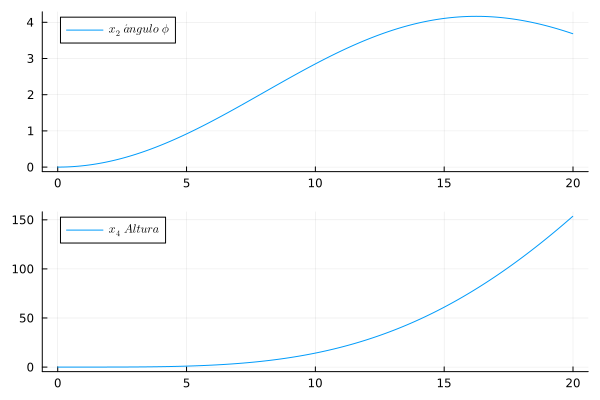

In [43]:
P1=plot(t, x2, label=L"x_2 \ \'angulo \  \phi", lw=1)
P2=plot(t, x4, label=L"x_4 \ Altura", lw=1)
P3=plot(t, acc, label=L"Entrada \ u_t.", lw=1)
plot(P1, P2, layout=(2,1) )